# 模型选择、欠拟合和过拟合
## 多项式回归

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

### 生成数据集

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [4]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[1.2061],
         [1.8527]]),
 tensor([[1.0000e+00, 1.2061e+00, 7.2729e-01, 2.9238e-01, 8.8158e-02, 2.1265e-02,
          4.2744e-03, 7.3645e-04, 1.1103e-04, 1.4878e-05, 1.7944e-06, 1.9674e-07,
          1.9773e-08, 1.8344e-09, 1.5803e-10, 1.2706e-11, 9.5778e-13, 6.7949e-14,
          4.5528e-15, 2.8900e-16],
         [1.0000e+00, 1.8527e+00, 1.7162e+00, 1.0599e+00, 4.9090e-01, 1.8190e-01,
          5.6166e-02, 1.4865e-02, 3.4426e-03, 7.0867e-04, 1.3129e-04, 2.2113e-05,
          3.4141e-06, 4.8655e-07, 6.4388e-08, 7.9527e-09, 9.2086e-10, 1.0036e-10,
          1.0329e-11, 1.0072e-12]]),
 tensor([5.6231, 7.3898]))

### 对模型进行训练和测试

In [5]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

### [**三阶多项式函数拟合(正常)**]

weight: [[ 5.018855   1.3239207 -3.4181309  5.3033886]]


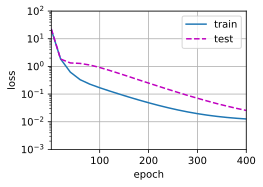

In [7]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

### [**线性函数拟合(欠拟合)**]

weight: [[3.4630692 3.4446635]]


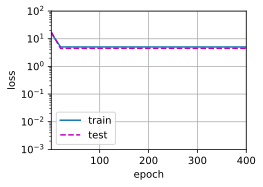

In [8]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

### [**高阶多项式函数拟合(过拟合)**]

weight: [[ 4.9976535   1.2769787  -3.3140926   5.2692204  -0.3167501   1.0751215
   0.09507629  0.25511158  0.06926554  0.057988    0.16817646  0.13433476
  -0.04966099  0.02856928 -0.08903239 -0.07389547 -0.17960203  0.0597747
   0.01440126 -0.16753274]]


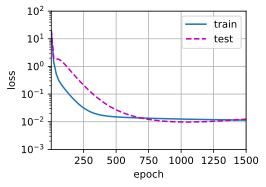

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)